# Imports

In [ ]:
# Usual stuff
import numpy as np
import matplotlib.pyplot as plt

# Animation
from matplotlib import animation

# Colors
import matplotlib.colors as mcolors

# Colormap normalization
mcolors_norm = mcolors.Normalize(vmin=0, vmax=1)

from PIL import Image

# Definitions

In [2]:
# Energy scale (we also have a = 1)
t = 1


# Dispersion for a cubic TB model with NN only
def epsilon(kx: float | np.ndarray = np.pi/2, ky: float | np.ndarray = np.pi/2, kz: float | np.ndarray = np.pi/2):
    return -2 * t * (np.cos(kx) + np.cos(ky) + np.cos(kz))


# Compute Ek
def spectral(eps: float | np.ndarray, mu: float, U: float, ne: float) -> tuple:

    # Compute W
    wk = np.sqrt(eps**2 + U**2 - 2 * U * eps * (1 - ne))

    # Compute E+-
    Ep = 0.5 * (eps + U - 2 * mu + wk)
    Em = 0.5 * (eps + U - 2 * mu - wk)

    # Compute Z+-
    frac = (eps - (1-ne) * U) / wk

    Zp = 0.5 * (1 + frac)
    Zm = 0.5 * (1 - frac)

    return Ep, Em, Zp, Zm


def nascent_delta(x: float | np.ndarray, gam: float, func: int = 1) -> float | np.ndarray:
    
    if func == 1:
        return gam / (np.pi * (x * x + gam * gam))
    elif func == 2:
        return np.exp(-x * x / (gam * gam)) / (gam * np.sqrt(np.pi))
    else:
        return -1.0

# Compute DOS

## Tight-Binding in 1D 

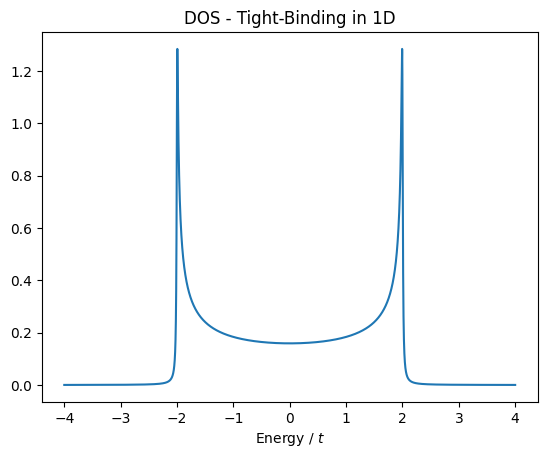

In [3]:
# Physical Parameters
N = 4000

U = 0
mu = 0
ne = 1


# Plotting Parameters
emin = -4
emax = +4

points = 40000
gam = 0.01


omega = np.linspace(emin, emax, points)
dos = np.zeros_like(omega)
for m in range(0, N):
    # Compute energy for this k
    ek = epsilon(2 * np.pi * m / N, np.pi/2, np.pi/2)

    # Add a delta at this energy
    dos += nascent_delta(omega - ek, gam, 1) / N


plt.title("DOS - Tight-Binding in 1D")
plt.xlabel("Energy / $t$")
plt.plot(omega, dos)

## Hubbard Model in 1D

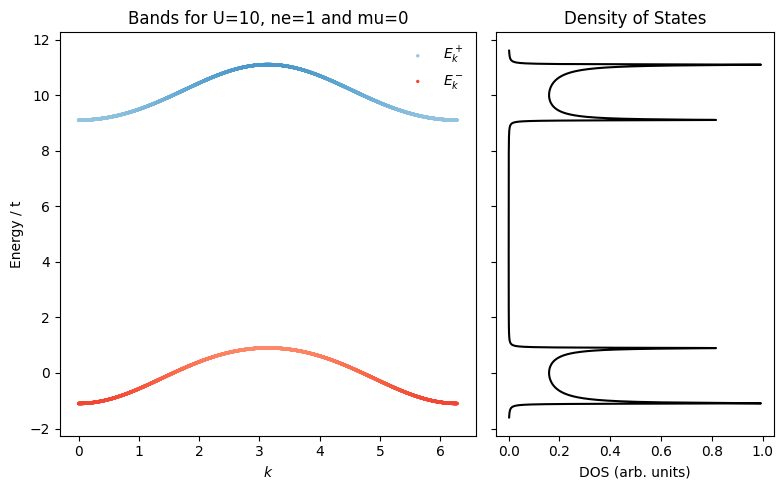

In [ ]:
def visualize_hubbard(N: int, U: float, mu: float, ne: float, points: int, gam: float, text: bool = False):

    # Evaluate the dispersion for a 1D k-grid
    kx = 2.0 * np.pi * np.arange(N) / N
    ee = epsilon(kx, np.pi/2, np.pi/2)

    # Compute dispersion relation
    eepp, eemm, zzpp, zzmm = spectral(ee, mu, U, ne)

    # Determine range
    emin = np.min(eemm) - 0.5
    emax = np.max(eepp) + 0.5

    # Setup arrays for ploting
    omega = np.linspace(emin, emax, points)
    dos = np.zeros_like(omega)

    # Compute DOS
    for Ep, Em, Zp, Zm in zip(eepp, eemm, zzpp, zzmm):
        dos += Zp * nascent_delta(omega - Ep, gam)
        dos += Zm * nascent_delta(omega - Em, gam)

    # Normalize
    dos /= N


    # Show analysis
    if text:

        # Sanity Checks
        print("Weights add to 1? ", np.allclose(zzpp + zzmm, 1.0))
        print("Range of E-:", np.min(eemm), np.max(eemm))
        print("Range of E+:", np.min(eepp), np.max(eepp))
        print("\n")

        # Integral over each band
        if np.max(eemm) < np.min(eepp):
            print("Bands are separate!")

            midpoint = (np.max(eemm) + np.min(eepp)) / 2

            maskm = omega < midpoint
            maskp = omega > midpoint

            print("Integral of DOS over lower band:", np.trapz(dos[maskm], omega[maskm]))
            print("Integral of DOS over upper band:", np.trapz(dos[maskp], omega[maskp]))


    return kx, eepp, eemm, zzpp, zzmm, omega, dos

    

# Example
N = 4000
U = 10
mu = 0
ne = 1

# Get plot
kx, eepp, eemm, zzpp, zzmm, omega, dos = visualize_hubbard(N, U, mu, ne, points=40000, gam=0.01)

# Make a side-by-side plot: bands (left) and DOS (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), sharey=True, gridspec_kw={'width_ratios': [1.5, 1]})


# Upper band with Z+ as color
sc1 = ax1.scatter(kx, eepp, c=zzpp, cmap='Blues', norm=mcolors_norm, s=2, label=r"$E_k^+$")

# Lower band with Z- as color
sc2 = ax1.scatter(kx, eemm, c=zzmm, cmap='Reds', norm=mcolors_norm, s=2, label=r"$E_k^-$")


# --- Density of States ---
ax2.plot(dos, omega / t, 'k-')
ax2.set_xlabel('DOS (arb. units)')
ax2.set_title('Density of States')


# Text of the plot
ax1.set_xlabel(r'$k$')
ax1.set_ylabel('Energy / t')
ax1.set_title(f'Bands for U={U}, ne={ne} and mu={mu}')
ax1.legend(frameon=False, loc="upper right")

# Make layout nice
plt.tight_layout()
plt.show()

In [25]:
# Parameters
N = 4000
mu = 0
ne = 1

Umin = 0
Umax = 5
Usteps = 25
uu = np.linspace(Umin, Umax, Usteps)


# --- Update rule ---
def update(frame, ax1, ax2, scatters, lines, results):
    # Unpack data
    kx, eepp, eemm, zzpp, zzmm, omega, dos, U, mu = results[frame]

    # Update scatter data (bands with Z color)
    scatters['eepp'].set_offsets(np.c_[kx, eepp])
    scatters['eepp'].set_array(zzpp)

    scatters['eemm'].set_offsets(np.c_[kx, eemm])
    scatters['eemm'].set_array(zzmm)

    # Update DOS line
    lines['dos'].set_data(dos, omega / t)

    # Update title
    ax1.set_title(f'Bands for U={U:.2f}, ne={ne} and mu={mu:.2f}')

    return list(scatters.values()) + list(lines.values())


def makeGIF(N: int, mu: float, ne: float, uu: np.ndarray, change_mu: bool = True):
    # Compute data
    results = []
    for U in uu:
        # Keep bands fixed up to first order in U
        if change_mu:
            mu = (ne/2) * U
        
        kx, eepp, eemm, zzpp, zzmm, omega, dos = visualize_hubbard(N, U, mu, ne, points=4000, gam=0.01)
        results.append((kx, eepp, eemm, zzpp, zzmm, omega, dos, U, mu))

    # Start the plot
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(8, 5), sharey=True, gridspec_kw={'width_ratios': [1.5, 1]}
    )
    ax1.set_xlabel(r'$k$')
    ax1.set_ylabel('Energy / t')
    ax1.set_ylim(-1.5 - Umax, 1.5 + Umax)
    ax2.set_xlabel('DOS (arb. units)')
    ax2.set_title('Density of States')

    # First frame
    kx, eepp, eemm, zzpp, zzmm, omega, dos, U, mu = results[0]

    # Initialize scatter objects (with color encoding)
    scatters = {
        'eepp': ax1.scatter(kx, eepp, c=zzpp, cmap='Blues', vmin=0, vmax=1, s=2, label=r"$E_k^+$"),
        'eemm': ax1.scatter(kx, eemm, c=zzmm, cmap='Reds', vmin=0, vmax=1, s=2, label=r"$E_k^-$")
    }

    # Initialize DOS line
    lines = {
        'dos': ax2.plot(dos, omega / t, 'k-')[0]
    }

    # Legend
    ax1.legend(frameon=False, loc="upper right")

    # Animate
    ani = animation.FuncAnimation(fig, update, frames=len(results), fargs=(ax1, ax2, scatters, lines, results), interval=300, blit=True)
    ani.save(f"01-Hubbard-{N}-{ne}.gif", writer="pillow")
    plt.close()


makeGIF(N, mu, ne, uu)